# A1 assignment's notebook for Complex Networks at URV 2025

## Authors:

Lobo Santos, Antonio
Kasa, Andrar

 ## Requirements and Constants
 This cell imports all the necessary libraries for data handling, numerical operations, plotting, and network analysis. 
 It also sets up important constant like Dataset Path.


In [25]:
# Requirements
import pandas as pd          # For dataframes and analysis
import numpy as np           # For numerical operations
import matplotlib.pyplot as plt  # For plotting
from matplotlib import rcParams
from matplotlib import colors
import random as random      # For randomness if needed
import networkx as nx        # For network tools
import os                    # For file management
from tabulate import tabulate # For table printing
import math                  # For mathematical operations
import itertools              # For iterations

DATASET_PATH = os.path.join("..","Datasets") # Path to the datasets folder

### Reading a Pajek (.net) File 
This cell defines a function `read_network` which takes a filepath to a Pajek file (with extension `.net`) and returns a NetworkX graph. Internally, it uses `nx.read_pajek` to read the network and then converts it to a simple `nx.Graph` (if the network is undirected)

In [18]:
def read_network(filepath):
    """
    Reads a network stored in Pajek (.net) format and returns a NetworkX graph.
    
    Parameters:
        filepath (str): Path to the .net file.
        
    Returns:
        G (nx.Graph or nx.DiGraph): The resulting network.
    """
    # Read the network using NetworkX's read_pajek function
    G = nx.read_pajek(filepath)
    
    # Optionally, convert to a simple Graph if you want to ignore parallel edges or self-loops.
    if G.is_directed():
        G = nx.DiGraph(G)
    else:
        G = nx.Graph(G)
        
    return G

# Example usage:
network_path = os.path.join(DATASET_PATH, "net1.net")
G = read_network(network_path)


# Part 1: Structural characterization of networks

## Macroscopic Analysis

### Computing Network Metrics 
This cell defines a function `compute_network_metrics` that computes key macroscopic metrics of the network: - Number of nodes and edges - Minimum, maximum, and average degree - Average clustering coefficient - Degree assortativity coefficient - Average path length and network diameter (computed on the largest connected component if the graph is not connected) The results are returned as a pandas DataFrame.

In [15]:
def compute_network_metrics(G, graph_name):
    """
    Computes several network metrics and returns them in a pandas DataFrame.
    
    Metrics computed:
      - Number of nodes
      - Number of edges
      - Minimum degree, maximum degree, and average degree
      - Average clustering coefficient
      - Degree assortativity
      - Average path length (for largest connected component if the network is not connected)
      - Diameter (for largest connected component if the network is not connected)
    
    Parameters:
        G (nx.Graph or nx.DiGraph): The networkx graph.
        graph_name (str): The name of the graph to use as the index for the DataFrame.
        
    Returns:
        metrics_df (pd.DataFrame): DataFrame with the computed metrics.
    """
    # Basic metrics
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()
    degrees = [d for n, d in G.degree()]
    min_degree = np.min(degrees)
    max_degree = np.max(degrees)
    avg_degree = np.mean(degrees)
    
    # Average clustering coefficient
    avg_clustering = nx.average_clustering(G)
    
    # Degree assortativity
    assortativity = nx.degree_assortativity_coefficient(G)
    
    # For metrics that require connectivity (average path length and diameter),
    # we use the largest connected component if G is not connected.
    if nx.is_connected(G):
        avg_path_length = nx.average_shortest_path_length(G)
        diameter = nx.diameter(G)
    else:
        # Get the largest connected component
        largest_cc = max(nx.connected_components(G), key=len)
        subgraph = G.subgraph(largest_cc)
        avg_path_length = nx.average_shortest_path_length(subgraph)
        diameter = nx.diameter(subgraph)
    
    # Compile the metrics into a dictionary
    metrics = {
        "Number of Nodes": [num_nodes],
        "Number of Edges": [num_edges],
        "Min Degree": [min_degree],
        "Max Degree": [max_degree],
        "Average Degree": [avg_degree],
        "Average Clustering Coefficient": [avg_clustering],
        "Degree Assortativity": [assortativity],
        "Average Path Length": [avg_path_length],
        "Diameter": [diameter]
    }
    
    # Create a DataFrame from the dictionary and set the index to the provided graph name
    metrics_df = pd.DataFrame(metrics, index=[graph_name])
    
    return metrics_df

# # Example usage:
# metrics_df = compute_network_metrics(G, "network 1")
# metrics_df


### Plotting Degree Distribution Histograms 
This function, `plot_degree_distributions`, accepts a parameter `plot_type` that determines the visualization mode: - **'both'**: Displays a single figure with two subplots—one for the linear histogram and one for the log-log histogram. - **'linear'**: Displays only the linear scale histogram in a larger, standalone plot. - **'loglog'**: Displays only the log-log histogram in a larger, standalone plot. This flexibility allows the user to choose between a combined view or a more detailed focus on one of the visualizations.
Based on both visualizations authors decide a specific one for each of the networks provided.

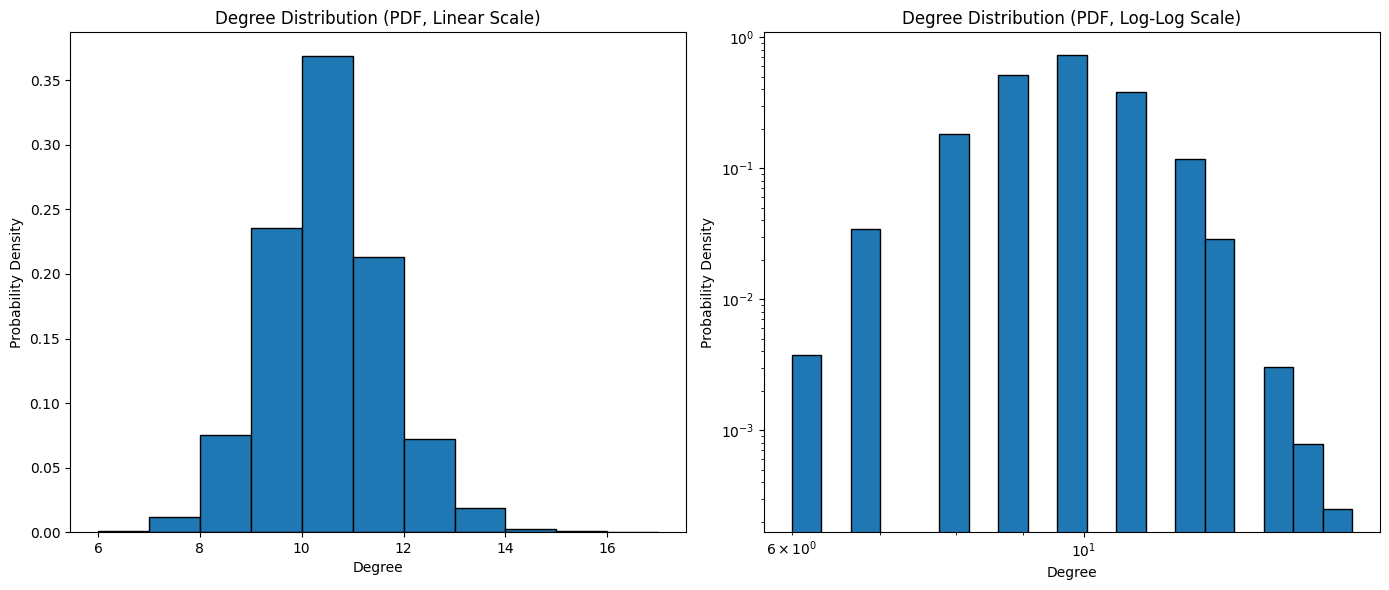

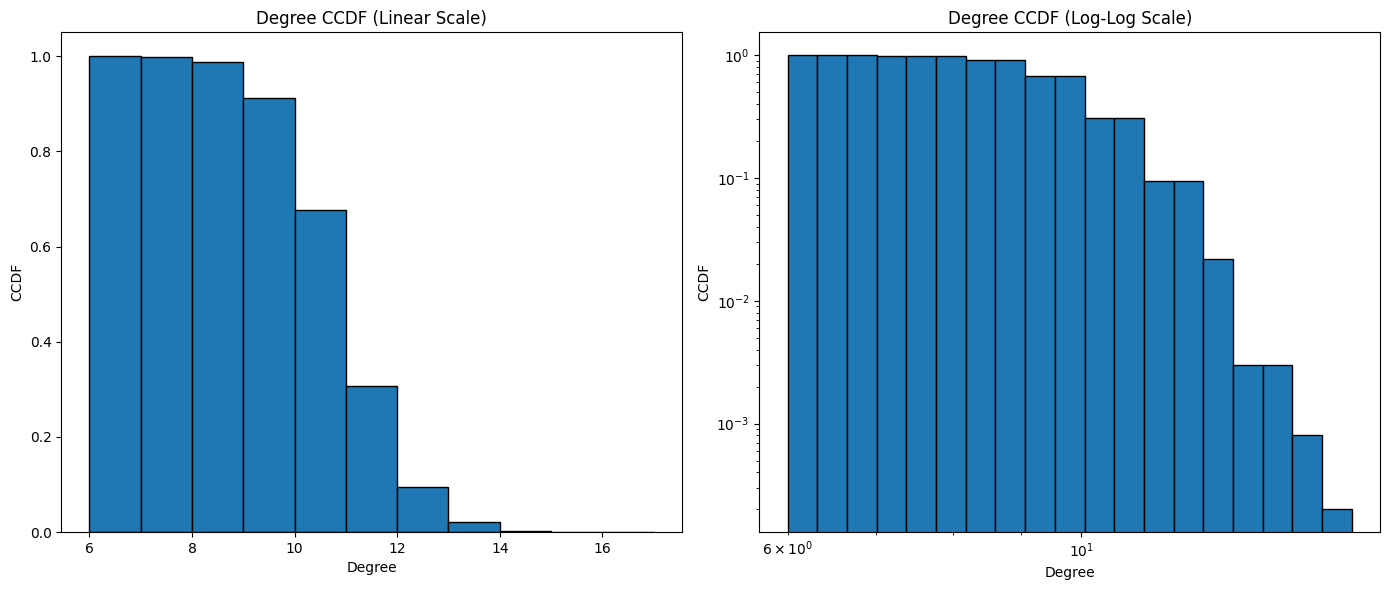

In [21]:
def plot_degree_distributions(G, plot_type='both', use_cdf=False):
    """
    Plots either the PDF or the CCDF of node degrees in a network, in linear
    and/or log-log scale, depending on the selected plot_type.

    Parameters:
        G (nx.Graph or nx.DiGraph): The networkx graph.
        plot_type (str): Visualization mode, with three options:
                         'both'   -> Plot both the linear and log-log histograms side by side.
                         'linear' -> Plot only the linear histogram in a standalone, larger plot.
                         'loglog' -> Plot only the log-log histogram in a standalone, larger plot.
                         Default is 'both'.
        use_cdf (bool): If False (default), plot the PDF (probability density) histogram.
                        If True, plot the CCDF (complementary cumulative distribution).
    """
    # Get the degree of each node
    degrees = [d for _, d in G.degree()]

    # Define linear bins (from min degree to max degree + 1)
    k_min = min(degrees)
    k_max = max(degrees)
    linear_bins = range(k_min, k_max + 2)

    # Define logarithmic bins for the log-log histogram
    # Start from max(1, k_min) to avoid log(0)
    num_log_bins = 20
    log_bins = np.logspace(
        np.log10(max(k_min, 1)),  # lower bound in log-scale
        np.log10(k_max),          # upper bound in log-scale
        num=num_log_bins
    )

    # Decide histogram parameters depending on PDF vs CCDF
    if use_cdf:
        # CCDF => cumulative=-1
        cumulative_setting = -1
        hist_title_linear = "Degree CCDF (Linear Scale)"
        hist_title_loglog = "Degree CCDF (Log-Log Scale)"
        y_label = "CCDF"
    else:
        # PDF => cumulative=False
        cumulative_setting = False
        hist_title_linear = "Degree Distribution (PDF, Linear Scale)"
        hist_title_loglog = "Degree Distribution (PDF, Log-Log Scale)"
        y_label = "Probability Density"

    if plot_type == 'both':
        # Create a figure with two subplots side by side
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))

        # --- Linear scale histogram ---
        axes[0].hist(
            degrees,
            bins=linear_bins,
            edgecolor='black',
            density=True,
            cumulative=cumulative_setting
        )
        axes[0].set_title(hist_title_linear)
        axes[0].set_xlabel("Degree")
        axes[0].set_ylabel(y_label)

        # --- Log-log histogram ---
        axes[1].hist(
            degrees,
            bins=log_bins,
            edgecolor='black',
            density=True,
            cumulative=cumulative_setting
        )
        axes[1].set_xscale("log")
        axes[1].set_yscale("log")
        axes[1].set_title(hist_title_loglog)
        axes[1].set_xlabel("Degree")
        axes[1].set_ylabel(y_label)

        plt.tight_layout()
        plt.show()

    elif plot_type == 'linear':
        # Create a larger standalone plot for the linear histogram
        plt.figure(figsize=(8, 6))
        plt.hist(
            degrees,
            bins=linear_bins,
            edgecolor='black',
            density=True,
            cumulative=cumulative_setting
        )
        plt.title(hist_title_linear)
        plt.xlabel("Degree")
        plt.ylabel(y_label)
        plt.tight_layout()
        plt.show()

    elif plot_type == 'loglog':
        # Create a larger standalone plot for the log-log histogram
        plt.figure(figsize=(8, 6))
        plt.hist(
            degrees,
            bins=log_bins,
            edgecolor='black',
            density=True,
            cumulative=cumulative_setting
        )
        plt.xscale("log")
        plt.yscale("log")
        plt.title(hist_title_loglog)
        plt.xlabel("Degree")
        plt.ylabel(y_label)
        plt.tight_layout()
        plt.show()

    else:
        raise ValueError("Invalid plot_type. Choose 'both', 'linear', or 'loglog'.")

# # Example usage:
# # For both histograms in one figure:
plot_degree_distributions(G, plot_type='both')
# #
# # For a larger linear histogram:
# plot_degree_distributions(G, plot_type='linear')
# #
# # For a larger log-log histogram:
# plot_degree_distributions(G, plot_type='loglog')
# # For both histograms in one figure, but using CCDF instead of PDF:
plot_degree_distributions(G, plot_type='both', use_cdf=True)


### Putting Everything Together:
In this section we will use previously defined functions to obtain and interpret the results of network 1 to 4.
With this purpose we create a function `analyze_network_macroscopic` that receives a name and computes and print all the macroscopic metrics.
These results will be discussed in `Assignment1_report.pdf`

In [13]:
def analyze_network_macroscopic(filepath, graph_name):
    """
    Analyzes the macroscopic properties of a network by reading the network,
    computing metrics, and plotting degree distribution histograms.
    
    Parameters:
        filepath (str): Path to the .net file.
        graph_name (str): The name of the graph to use for labeling.
        
    Returns:
        metrics_df (pd.DataFrame): DataFrame with the computed metrics.
    """
    # Read the network
    G = read_network(filepath)
    
    # Compute network metrics
    metrics_df = compute_network_metrics(G, graph_name)
    print(metrics_df)
    
    # Plot degree distributions
    plot_degree_distributions(G, plot_type='both')
    
    return metrics_df

# Example usage:
# metrics_df = analyze_network_macroscopic("Datasets/net1.net", "network 1")

#### Network 1:

In [ ]:
network_path = os.path.join(DATASET_PATH, "net1.net")
metrics_df = analyze_network_macroscopic(network_path, "network 1")
metrics_df

           Number of Nodes  Number of Edges  Min Degree  Max Degree  \
network 1             5000            25000           6          16   

           Average Degree  Average Clustering Coefficient  \
network 1            10.0                         0.41407   

           Degree Assortativity  Average Path Length  Diameter  
network 1             -0.009733             5.121125         8  


Number of Nodes  Number of Edges  Min Degree  Max Degree  \
network 1             5000            25000           6          16   

           Average Degree  Average Clustering Coefficient  \
network 1            10.0                         0.41407   

           Degree Assortativity  Average Path Length  Diameter  
network 1             -0.009733             5.121125         8

#### Network 2:

In [ ]:
network_path = os.path.join(DATASET_PATH, "net2.net")
metrics_df = analyze_network_macroscopic(network_path, "network 2")
metrics_df

           Number of Nodes  Number of Edges  Min Degree  Max Degree  \
network 2             5000            24873           1          24   

           Average Degree  Average Clustering Coefficient  \
network 2          9.9492                        0.002099   

           Degree Assortativity  Average Path Length  Diameter  
network 2             -0.005663              3.95605         7  


Number of Nodes  Number of Edges  Min Degree  Max Degree  \
network 2             5000            24873           1          24   

           Average Degree  Average Clustering Coefficient  \
network 2          9.9492                        0.002099   

           Degree Assortativity  Average Path Length  Diameter  
network 2             -0.005663              3.95605         7

#### Network 3:

           Number of Nodes  Number of Edges  Min Degree  Max Degree  \
network 3             5000            23508           3         732   

           Average Degree  Average Clustering Coefficient  \
network 3          9.4032                        0.086214   

           Degree Assortativity  Average Path Length  Diameter  
network 3              -0.13386             3.008243         5  


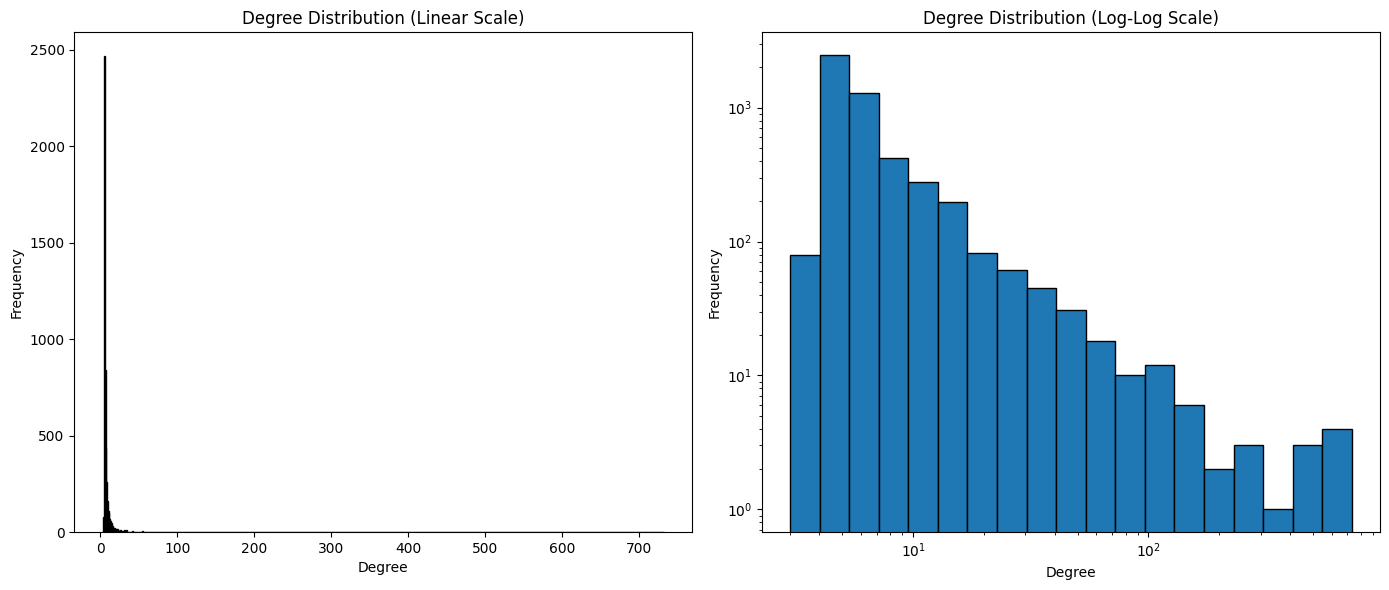

Number of Nodes  Number of Edges  Min Degree  Max Degree  \
network 3             5000            23508           3         732   

           Average Degree  Average Clustering Coefficient  \
network 3          9.4032                        0.086214   

           Degree Assortativity  Average Path Length  Diameter  
network 3              -0.13386             3.008243         5

In [ ]:
network_path = os.path.join(DATASET_PATH, "net3.net")
metrics_df = analyze_network_macroscopic(network_path, "network 3")
metrics_df

#### Network 4:

In [24]:
network_path = os.path.join(DATASET_PATH, "net4.net")
metrics_df = analyze_network_macroscopic(network_path, "network 4")
metrics_df

NameError: name 'analyze_network_macroscopic' is not defined

## Microscopic Analysis

### Computing Node Centralities
This cell defines a function `compute_centrality_measures` which calculates different centrality measures using built-in NetworkX functions: - PageRank - Eigenvector Centrality - Betweenness Centrality - Closeness Centrality The function then identifies the top 5 nodes for each centrality metric and prints the results.

In [23]:
def compute_centrality_measures(G):
    """
    Computes several node centralities and prints a formatted table showing the top 5 nodes for each metric.
    
    Centrality metrics computed:
      - PageRank
      - Eigenvector Centrality
      - Betweenness Centrality
      - Closeness Centrality
      
    Parameters:
        G (nx.Graph or nx.DiGraph): The networkx graph.
        
    Returns:
        centralities (dict): Dictionary containing centrality dictionaries for each metric.
    """
    # Compute centralities
    page_rank = nx.pagerank(G)
    eigenvector = nx.eigenvector_centrality(G, max_iter=1000)
    betweenness = nx.betweenness_centrality(G)
    closeness = nx.closeness_centrality(G)
    
    centralities = {
        "PageRank": page_rank,
        "Eigenvector": eigenvector,
        "Betweenness": betweenness,
        "Closeness": closeness
    }
    
    # Function to get top n nodes sorted by centrality score
    def top_n(centrality_dict, n=5):
        return sorted(centrality_dict.items(), key=lambda item: item[1], reverse=True)[:n]
    
    # Prepare table data
    table_data = []
    for metric, centrality in centralities.items():
        top_nodes = top_n(centrality)
        for rank, (node, score) in enumerate(top_nodes, start=1):
            table_data.append([metric, rank, node, score])
    
    headers = ["Centrality Metric", "Rank", "Node", "Score"]
    print(tabulate(table_data, headers=headers, tablefmt="fancy_grid", floatfmt=".4f"))
    
    return centralities

# Example usage:
centrality_measures = compute_centrality_measures(G)


╒═════════════════════╤════════╤════════╤═════════╕
│ Centrality Metric   │   Rank │   Node │   Score │
╞═════════════════════╪════════╪════════╪═════════╡
│ PageRank            │      1 │   1693 │  0.0003 │
├─────────────────────┼────────┼────────┼─────────┤
│ PageRank            │      2 │   1579 │  0.0003 │
├─────────────────────┼────────┼────────┼─────────┤
│ PageRank            │      3 │   4891 │  0.0003 │
├─────────────────────┼────────┼────────┼─────────┤
│ PageRank            │      4 │    651 │  0.0003 │
├─────────────────────┼────────┼────────┼─────────┤
│ PageRank            │      5 │   3659 │  0.0003 │
├─────────────────────┼────────┼────────┼─────────┤
│ Eigenvector         │      1 │    651 │  0.0286 │
├─────────────────────┼────────┼────────┼─────────┤
│ Eigenvector         │      2 │   1937 │  0.0265 │
├─────────────────────┼────────┼────────┼─────────┤
│ Eigenvector         │      3 │   4526 │  0.0256 │
├─────────────────────┼────────┼────────┼─────────┤
│ Eigenvecto

# Part 2: Models

### Model Verification


In this section, we compute additional metrics to validate the models hypothesized from the previous analysis.

#### Network 1


#### Network 2


#### Network 3


#### Network 4


## Network 5 Visualization

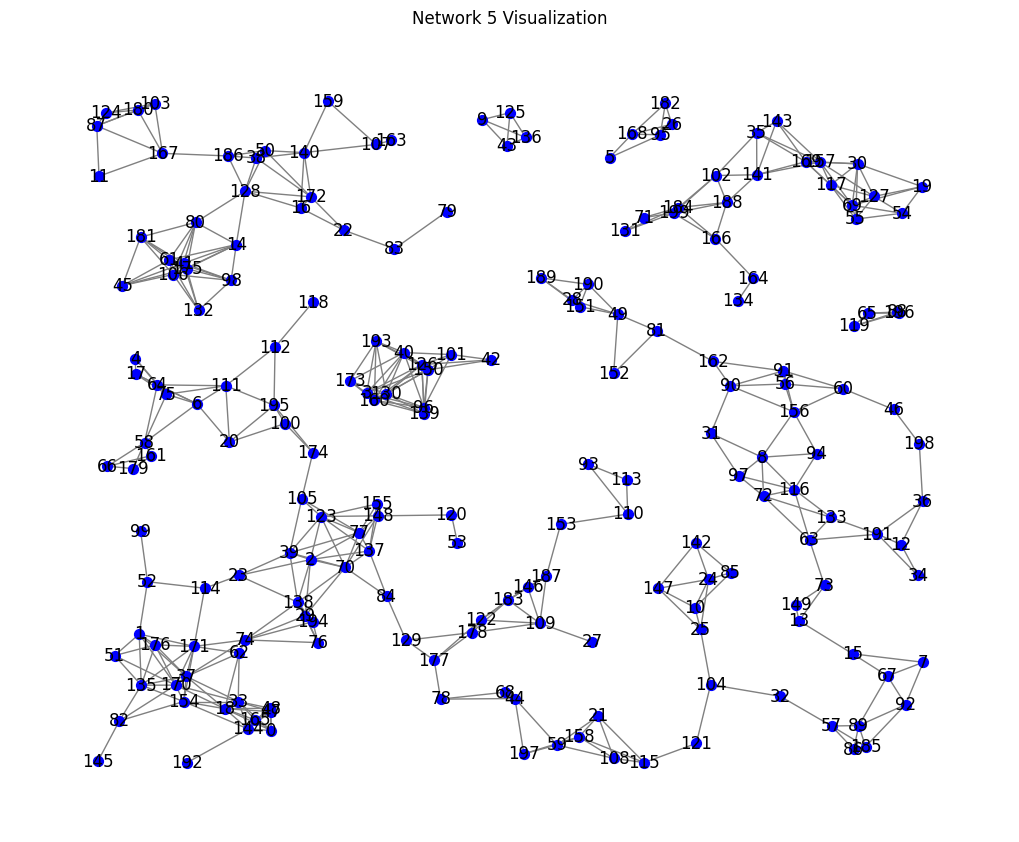

In [12]:
# Read the network
network_path = os.path.join(DATASET_PATH, "net5.net")
G_net5 = read_network(network_path)

# Read the positions from the file
positions_net5 = {}
positions_net5_path = os.path.join(DATASET_PATH, "positions_net5.txt")
with open(positions_net5_path, "r") as f:
    next(f)  # Skip the first line (header)
    for line in f:
        node, x, y = line.strip().split()
        positions_net5[node] = (float(x), float(y))

# Plot the network
plt.figure(figsize=(10, 8))
nx.draw(G_net5, pos=positions_net5, with_labels=True, node_size=50, node_color='blue', edge_color='gray')
plt.title("Network 5 Visualization")
plt.show()

#### Validate Model:

To validate the hypothesis that nodes are connected based on spatial proximity under a threshold distance \( r \), we follow these steps:

1. **Compute Distance Between All Pairs**  
   We calculate the Euclidean distance for every pair of nodes in the network.

2. **Identify Key Distances**  
   - Find the **maximum distance** between nodes that are connected in the original network ($ b $).  
   - Find the **minimum distance** between nodes that are not connected in the original network ($ a $).  
   - Compute the middle value as:  
     $$ r = \frac{a + b}{2} $$
     which serves as the connection threshold.

3. **Reconstruct the Network**  
   Using this threshold $ r $, we create a new graph where an edge exists between two nodes if their Euclidean distance is at most $ r $.

4. **Compare Original vs. Reconstructed Network**  
   - Compute the number of overlapping edges.
   - Calculate key similarity metrics:
     - **Jaccard Similarity**: Measures the fraction of common edges between both graphs.
       $$ J = \frac{|E_{\text{original}} \cap E_{\text{reconstructed}}|}{|E_{\text{original}} \cup E_{\text{reconstructed}}|} $$
     - **Recall**: The fraction of original edges correctly reconstructed.
       $$ R = \frac{|E_{\text{original}} \cap E_{\text{reconstructed}}|}{|E_{\text{original}}|} $$
     - **Precision**: The fraction of reconstructed edges that match the original graph.
       $$ P = \frac{|E_{\text{original}} \cap E_{\text{reconstructed}}|}{|E_{\text{reconstructed}}|} $$

By evaluating these metrics, we can determine how well a simple spatial distance-based model explains the observed network structure.






In [28]:
# Compute distances for all pairs
connected_distances = []
disconnected_distances = []

nodes = list(G_net5.nodes())

for u, v in itertools.combinations(nodes, 2):
    x1, y1 = positions_net5[u]
    x2, y2 = positions_net5[v]
    dist = math.sqrt((x1 - x2)**2 + (y1 - y2)**2)
    
    if G_net5.has_edge(u, v):
        connected_distances.append(dist)
    else:
        disconnected_distances.append(dist)

# Find max distance among connected nodes and min distance among disconnected nodes
max_connected = max(connected_distances)
min_disconnected = min(disconnected_distances)
threshold = 0.5 * (max_connected + min_disconnected)

print(f"Max distance among connected nodes: {max_connected:.4f}")
print(f"Min distance among disconnected nodes: {min_disconnected:.4f}")
print(f"Chosen threshold (midpoint): {threshold:.4f}")

# Reconstruct a graph based on this threshold
G_reconstructed = nx.Graph()
G_reconstructed.add_nodes_from(G_net5.nodes())

for u, v in itertools.combinations(nodes, 2):
    x1, y1 = positions_net5[u]
    x2, y2 = positions_net5[v]
    dist = math.sqrt((x1 - x2)**2 + (y1 - y2)**2)
    if dist <= threshold:
        G_reconstructed.add_edge(u, v)

# Compute overlap between original and reconstructed edges
edges_net5 = set(map(lambda e: tuple(sorted(e)), G_net5.edges()))
edges_rec = set(map(lambda e: tuple(sorted(e)), G_reconstructed.edges()))

overlap = edges_net5.intersection(edges_rec)
overlap_size = len(overlap)
union_size = len(edges_net5.union(edges_rec))

jaccard = overlap_size / union_size if union_size > 0 else 0
recall = overlap_size / len(edges_net5) if len(edges_net5) > 0 else 0
precision = overlap_size / len(edges_rec) if len(edges_rec) > 0 else 0

print(f"Number of overlapping edges: {overlap_size}")
print(f"Jaccard similarity (overlap/union): {jaccard:.4f}")
print(f"Recall (overlap/original): {recall:.4f}")
print(f"Precision (overlap/reconstructed): {precision:.4f}")


Max distance among connected nodes: 0.0900
Min distance among disconnected nodes: 0.0903
Chosen threshold (midpoint): 0.0901
Number of overlapping edges: 465
Jaccard similarity (overlap/union): 1.0000
Recall (overlap/original): 1.0000
Precision (overlap/reconstructed): 1.0000
